# sklearn Algorithms

This section aims to give you some awareness, if not a complete understanding, of the many algorithms implemented in sklearn.

The "no free lunch" theorem states that there is no single algorithm that performs optimally in all situations, so you need to know about a variety of techniques so you can apply the best technique for the job at hand.

We don't cover algorithms that we have already seen in this course, otherwise we'd be here all day!

It's split into three sections: classification, linear regression and clustering. We (almost) covered all of the dimensionality reduction techniques in other sections.

They're aren't many tasks to complete in this section. So I encourage you to have a play around with the algorithms and settings.

First we're going to get all the imports out of the way and write a few methods to help us with the plotting.

In [1]:
import warnings
from itertools import cycle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm
from matplotlib.patches import Ellipse
from pandas import Series
from scipy import linalg
from sklearn import cluster, datasets, metrics, mixture
from sklearn.cluster import AffinityPropagation, DBSCAN, spectral_clustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction import image
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels import api as sm
from statsmodels import graphics

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
h = .2  # step size in the mesh
colours = np.array(['#ff7f00','#377eb8','#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00'])
cm = plt.cm.RdBu


def plot_single(ax, clf, X, y, X_test=None, y_test=None):
    if clf is not None and (hasattr(clf, "decision_function") or hasattr(clf, "predict_proba")):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        elif hasattr(clf, "predict_proba"):
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        if len(Z.shape) == 1:
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.4)
        elif Z.shape[1] == 2:
            Z = Z[:, 1].reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.4)
        else:
            Z = Z.reshape((xx.shape[0], xx.shape[1], Z.shape[1]))
            Z[:, :,[0, 1, 2]] = Z[:, :,[0, 2, 1]]
            ax.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
    ax.scatter(X[:, 0], X[:, 1], c=colours[y], edgecolors=(0, 0, 0))
    if X_test is not None and y_test is not None:
        ax.scatter(X_test[:, 0], X_test[:, 1], c=colours[y_test], edgecolors=(1, 1, 1), alpha=0.6)

    ax.set_xticks(())
    ax.set_yticks(())
    plt.tight_layout()

In [3]:
n_samples=300

# Datasets
X, y = datasets.make_classification(n_features=2, n_redundant=0, n_informative=2,random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

moons = datasets.make_moons(noise=0.3, random_state=0)

circles = datasets.make_circles(noise=0.2, factor=0.5, random_state=1)

blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

centers = [[1, 1], [-1, -1], [1, -1]]
close_blobs = datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.6)

iris = datasets.load_iris()
iris = (iris.data, np.array(iris.target, dtype=int))


def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n))).astype(int)
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n))).astype(int)
    return X, y

## Classification

First we cover classification and the first plot is the massive comparison image you saw in the slides.

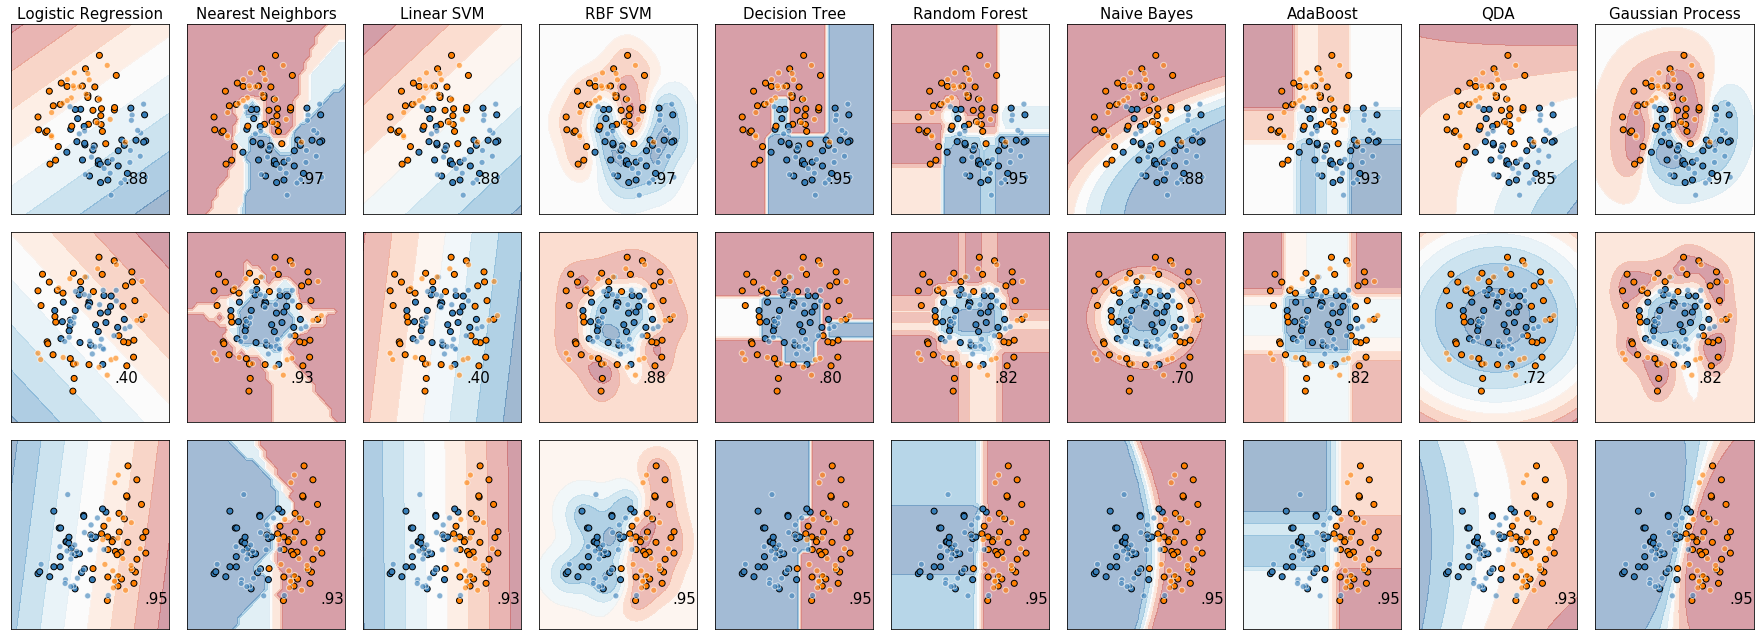

In [4]:
# A cannabalised version of http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

classifiers = (
    ("Logistic Regression", LogisticRegression()),
    ("Nearest Neighbors", KNeighborsClassifier(3)),
    ("Linear SVM", SVC(kernel="linear", C=0.025)),
    ("RBF SVM", SVC(gamma=2, C=1)),
    ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
    ("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    ("Naive Bayes", GaussianNB()),
    ("AdaBoost", AdaBoostClassifier()),
    ("QDA", QuadraticDiscriminantAnalysis()),
    ("Gaussian Process", GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True))
)

lots_of_data = [moons, circles, linearly_separable]

figure = plt.figure(figsize=(27, 9))
i = 1
for ds_cnt, ds in enumerate(lots_of_data):
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
    i += 1
    for name, clf in classifiers:
        ax = plt.subplot(len(lots_of_data), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        plot_single(ax, clf, X_train, y_train, X_test, y_test)

        if ds_cnt == 0:
            ax.set_title(name, fontsize=15)
        ax.text(X_train.max() - .3, X_train.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

### ADABOOST

ADABOOST is a fascinating ensemble algorithm that allows you merge the results of a set of other algorithms and then weight the isntances that it's not classifying.

Below we're using the standard decision tree as the base classifier, but if you have time you might want to...

Tasks:

- Try ADABOOST with a different base algorithm.

0.95


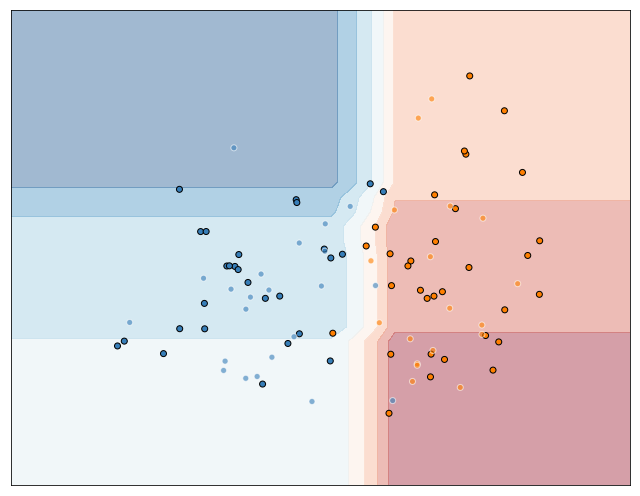

In [5]:
X, y = linearly_separable
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
        
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(9, 7))
plot_single(ax, clf, X_train, y_train, X_test, y_test)
plt.show()


### Linear Descriminant Analysis

LDA is the cousin of PCA. Instead of transforming dimensions, it reuses current dimensions and picks the dimension with best class separation. In a way, this belongs in the dimensionality reduction section. But it's use of class separation means its most often used in classification problems.

Below we're comparing the difference between PCA and LDA.

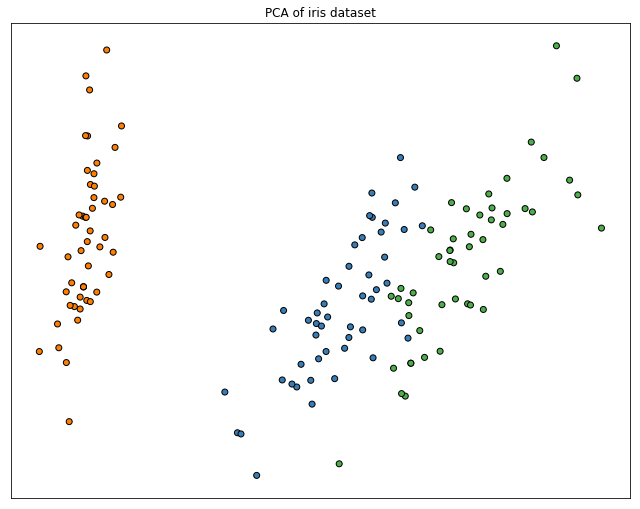

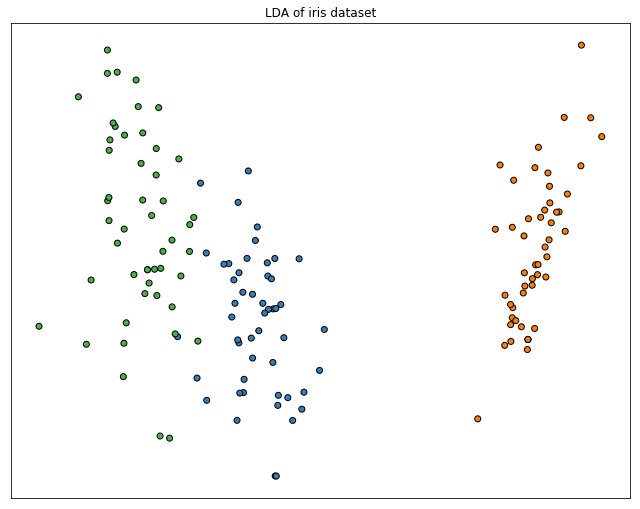

In [6]:
# Altered version of: http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

X, y = iris

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

fig, ax = plt.subplots(figsize=(9, 7))
plot_single(ax, None, X_r, y)
plt.title('PCA of iris dataset')
plt.show()

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

fig, ax = plt.subplots(figsize=(9, 7))
plot_single(ax, None, X_r2, y)
plt.title('LDA of iris dataset')
plt.show()

### LDA/QDA Classification

When using LDA/QDA for classification directly, this is simply the process of performing LDA/QDA then fitting gaussians to the data.

There's no reason why you couldn't use another classification algorithm instead.

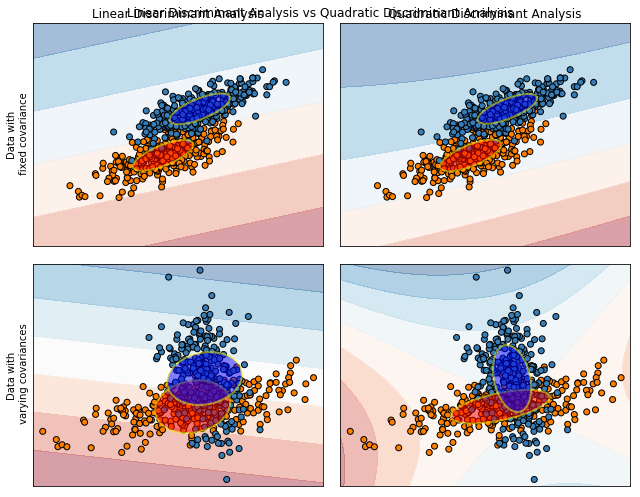

In [7]:
# Stripped down version of: http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')

fig = plt.figure(figsize=(9, 7))
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    clf = LinearDiscriminantAnalysis(solver="svd", store_covariance=True).fit(X, y)
    fig_index = 2 * i + 1
        
    ax = plt.subplot(2, 2, fig_index)
    plot_single(ax, clf, X, y)
    plot_lda_cov(clf, ax)
    plt.axis('tight')
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')
        
    fig_index = 2 * i + 2
    # Quadratic Discriminant Analysis
    clf = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X, y)
    ax = plt.subplot(2, 2, fig_index)
    plot_single(ax, clf, X, y)
    plot_qda_cov(clf, ax)
    plt.axis('tight')
    if fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis')
plt.show()

### Gaussian Process Classification

I found this the hardest algorithm to explain. Simplifying massively, a Gaussian Process is an inifinite array of gaussians. When you add datapoints it constrains those gaussians. I like to think of it like a Fourier series.

For classification purposes they are very similar to bayesian classifiers, with the difference being you can choose your own kernel. This is great because it allows you to select a kernel that best represent your data (or your prior knowledge).

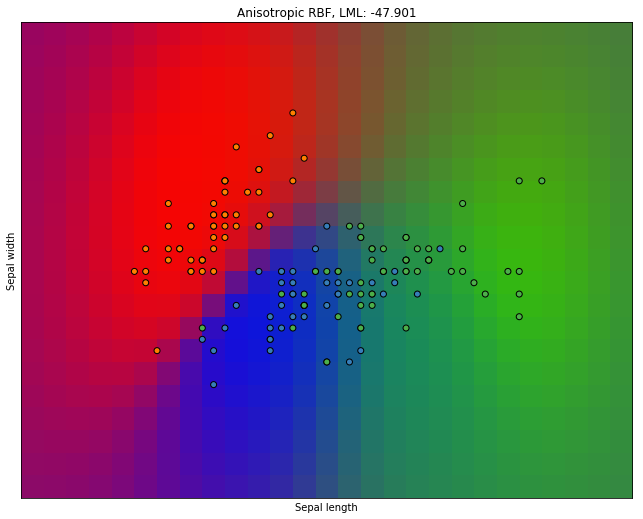

In [8]:
# Simplified version of: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_iris.html

X, y = iris
X = X[:, :2]  # we only take the first two features.

kernel = 1.0 * RBF([1.0, 1.0])
clf = GaussianProcessClassifier(kernel=kernel).fit(X, y)

fig, ax = plt.subplots(figsize=(9, 7))
plot_single(ax, clf, X, y)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("%s, LML: %.3f" % ("Anisotropic RBF", clf.log_marginal_likelihood(clf.kernel_.theta)))
plt.show()

## Regression

We haven't touched regression for a while, but it is very important in some domains.

Specifically we haven't talked about auto-regressive models nor much fitting models in general.

These few examples are about AR/MA/ARMA/ARIMA models and use a separate library called `statsmodels` (we saw this previously when removing cyclic influences from data). This is because there aren't any AR/MA/ARMA/ARIMA models in `sklearn`.

### Sunpot data

`pandas` makes a return here. Generally I use pandas all the time, but most of the data we'be been using is ready to use. For any "real" data, pandas is my goto choice.


In [9]:
print(sm.datasets.sunspots.NOTE) # Some info about the sunspot data

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [10]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008')) # Set the pandas index to a date range
del sunspots["YEAR"] # Delete the column called YEAR

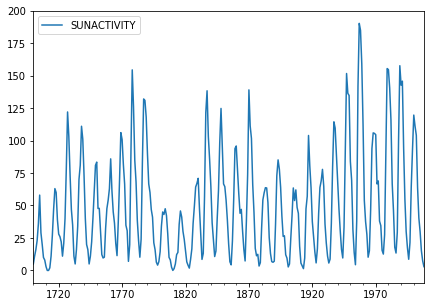

In [11]:
sunspots.plot(figsize=(7, 5))
plt.show()

#### ARMA model

Tasks

- Try playing about with the AR and MA orders

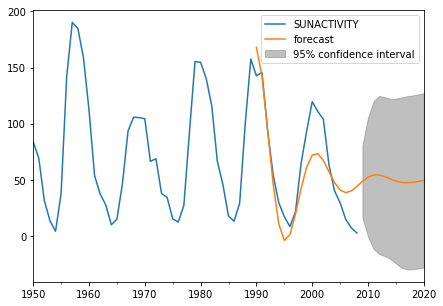

In [12]:
arma = sm.tsa.ARMA(sunspots, (2,2)) # Create a an ARMA model. Try playing with these values (the AR order and MA order)
results = arma.fit()

fig, ax = plt.subplots(figsize=(7, 5))
ax = sunspots.loc['1950':].plot(ax=ax)
fig = results.plot_predict('1990', '2020', dynamic=True, ax=ax, plot_insample=False)
plt.show()

#### ARMIMA model

Tasks:
    
- Try playing with the AR I and MA orders

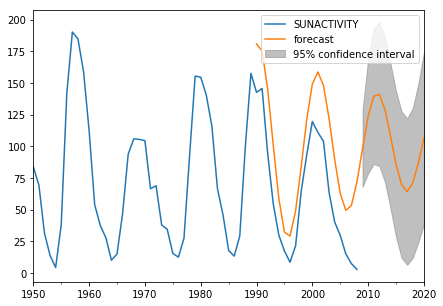

In [13]:
arma = sm.tsa.ARIMA(sunspots, (2,1,2)) # Create an ARIMA model. Try messing with these values.
results = arma.fit()

fig, ax = plt.subplots(figsize=(7, 5))
ax = sunspots.loc['1950':].plot(ax=ax)
fig = results.plot_predict('1990', '2020', dynamic=True, ax=ax, plot_insample=False)
plt.show()

#### Airline Passenger Data

A similar dataset but with an increasing trend. Remember what we said? ARMA models assume stationary data? ...

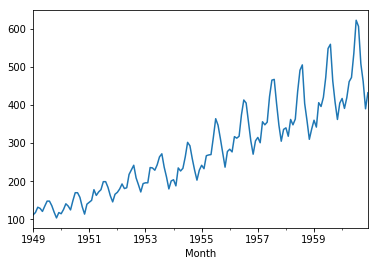

In [14]:
series = Series.from_csv('data/international-airline-passengers.csv', header=0)
series.plot()
plt.show()

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


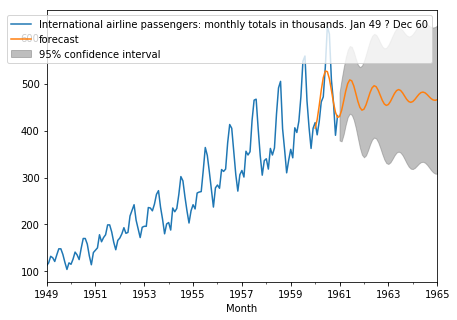

In [15]:
arma = sm.tsa.ARMA(series.astype(float), (3,2))
results = arma.fit()
fig, ax = plt.subplots(figsize=(7, 5))
ax = series.plot(ax=ax)
fig = results.plot_predict('1960-01-01', '1965-01-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()

It clearly doesn't work well.

Tasks:

- Fit a ARIMA model
- Optional: try detrending the data and fitting a ARMA model

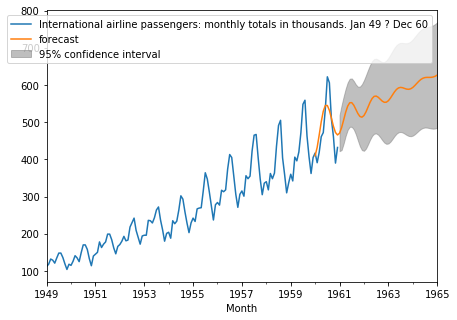

In [16]:
arma = sm.tsa.ARIMA(series.astype(float), (2,1,2))
results = arma.fit()
fig, ax = plt.subplots(figsize=(7, 5))
ax = series.plot(ax=ax)
fig = results.plot_predict('1960-01-01', '1965-01-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()

#### How do you choose AR/MA/I orders?

You use Autocorrelation function (ACF)/Partial Autocorrelation function (PACF) plots!

The ACF plot gives you an indication of the MA order. The PACF plot gives you an indication of AR order.

What we're looking for is a clear, obvious number of peaks at the start of the of the CFs.

By obvious, I mean statistically significant. This is represented by the confidence interval shaded in blue. If peaks are much greater than this then they are statistically significant.

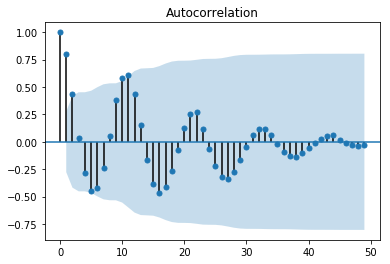

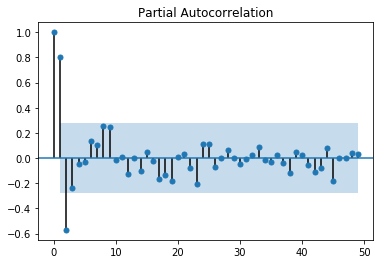

In [17]:
graphics.tsaplots.plot_acf(sunspots.iloc[:50])
plt.show()
graphics.tsaplots.plot_pacf(sunspots.iloc[:50])
plt.show()

We can see that the first two PACF components are much more significant than the the others. This is clear indication that a AR model of order 2 would fit the data well.

The ACF plot is a different story, however. The first two, maybe three are a little significant. But not much. There isn't much evidence to suggest that adding a MA term would help. At this point we should consider taking another look at the data.

If we plot the sunspot data again, we can see that just an AR model performs almost as well.

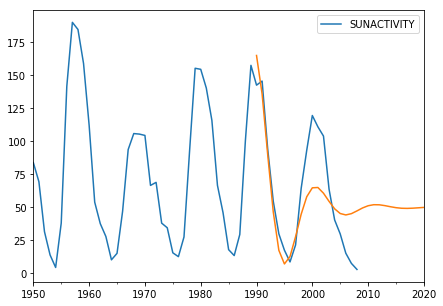

In [18]:
arma = sm.tsa.AR(sunspots)
results = arma.fit(2)

fig, ax = plt.subplots(figsize=(7, 5))
sunspots.loc['1950':].plot(ax=ax)
results.predict('1990', '2020', dynamic=True).plot(ax=ax)
plt.show()

## Clustering

There are a few more clustering algorithms that we need to take a look at.

Let's plot the comparison first.

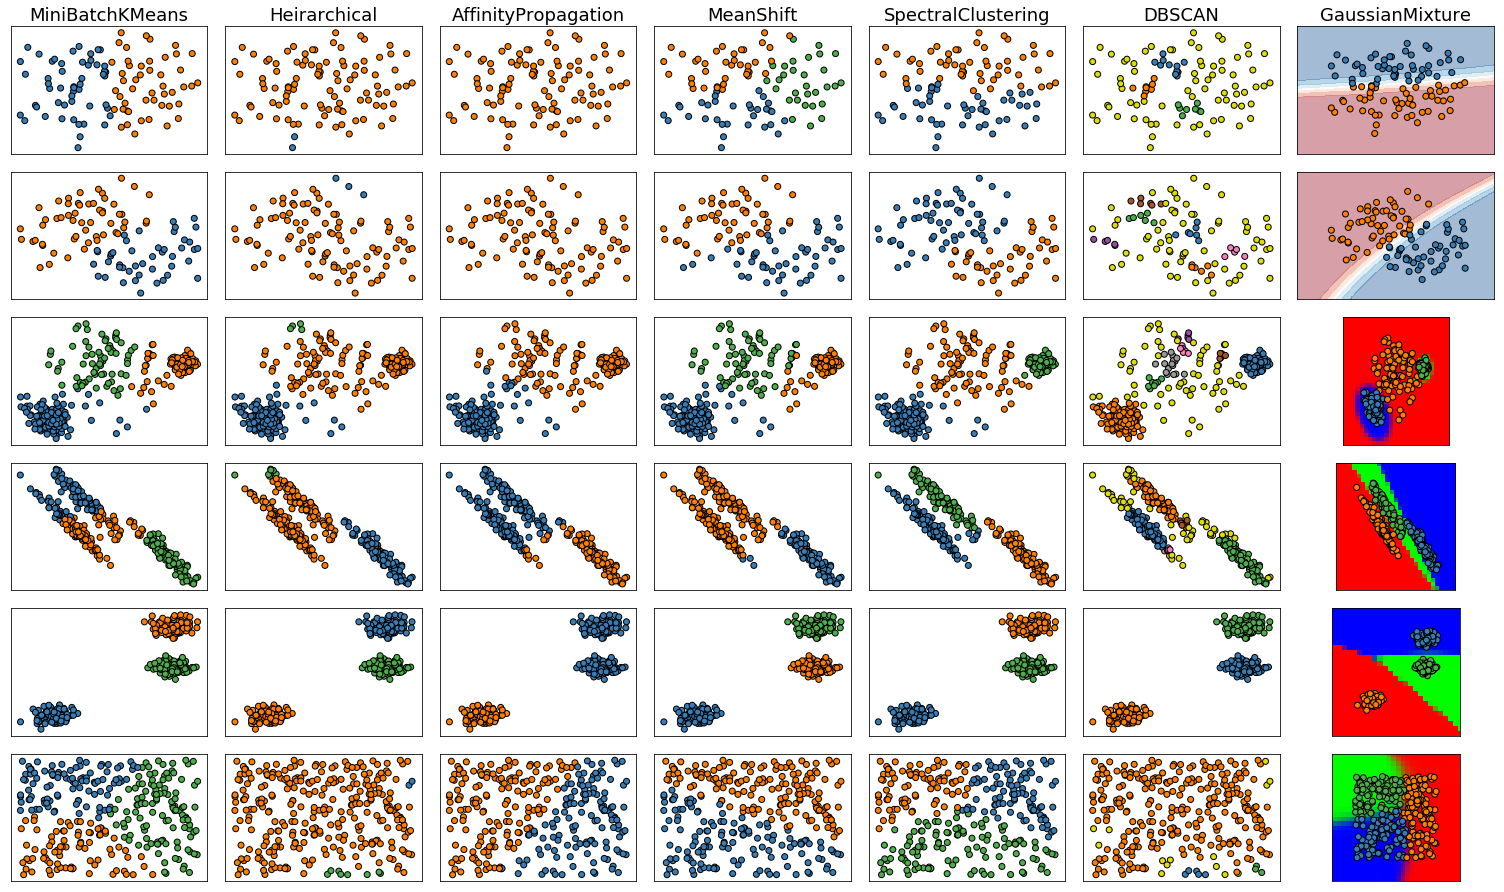

In [19]:
# A trimmed down version of http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

np.random.seed(0)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('Heirarchical', average_linkage),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('DBSCAN', dbscan),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        ax = plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        
        plot_single(ax, algorithm, X, y_pred)
        plot_num += 1

plt.show()

### Affinity Propagation

Affinity propagation is the technique that attempts to compare exemplars with the surrounding instances.

Tasks:

- Try playing around with the value for preference - read the docs
- Try another datset (you'll probably have to alter the preference value)

Estimated number of clusters: 3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.957


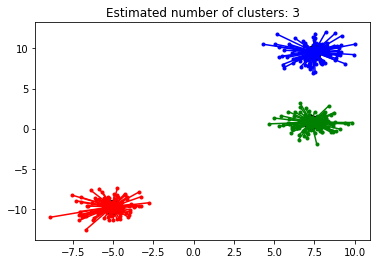

In [20]:
# Slightly altered version of: http://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html

X, y = blobs

# Compute Affinity Propagation
af = AffinityPropagation(preference=-100).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

for k, col in zip(range(n_clusters_), cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Mean Shift

This is the pretty simple algorithm that moves a kernel towards a dense region of points.

Tasks:

- Try editing the bandwidth
- Run the algorithm with another dataset.

number of estimated clusters : 3


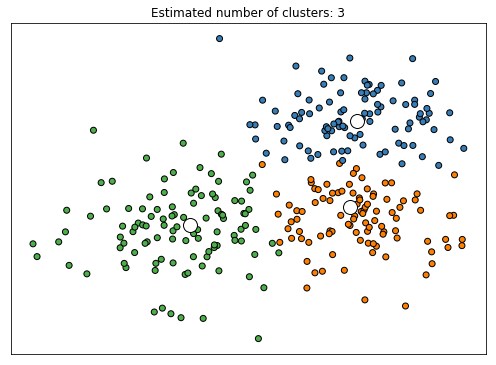

In [21]:
# Simplified version of: http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

# Compute clustering with MeanShift
X, y = close_blobs

# The following bandwidth can be automatically detected using
bandwidth = cluster.estimate_bandwidth(X, quantile=0.2, n_samples=500)

clf = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)
labels = clf.labels_
cluster_centers = clf.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result

fig, ax = plt.subplots(figsize=(7, 5))
plot_single(ax, clf, X, labels)
for k in range(n_clusters_):
    cluster_center = cluster_centers[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o', color='w', markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Spectral Clustering

Spectral clustering first performs dimensionality reduction, then k-means. This means it performs well with high-dimensional datasets, like images.

Tasks:

- Try increasing the radius of one of the circles
- Try altering the number of clusters
- Try moving the clusters around
- Optional: Try with a real image

/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


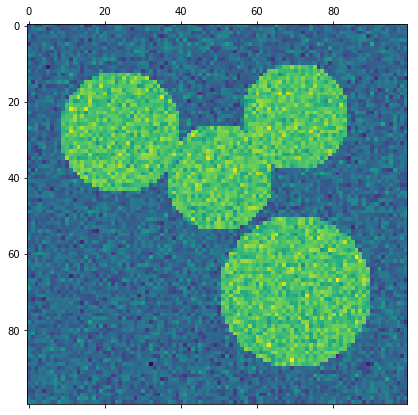

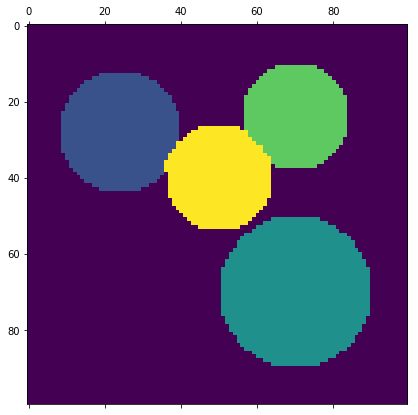

In [22]:
# Almost the same as: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (70, 70)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 20, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=4)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

fig, ax = plt.subplots(figsize=(9, 7))
ax.matshow(img)
fig, ax = plt.subplots(figsize=(9, 7))
ax.matshow(label_im)
plt.show()

### DBSCAN

This works pretty well even with noise, due to the ability to distinguish outliers. Consider it in the same realm as k-NN/k-means.

Tasks:

- Try with different datasets


Estimated number of clusters: 4
Homogeneity: 0.576
Completeness: 0.427
V-measure: 0.490
Adjusted Rand Index: 0.415
Adjusted Mutual Information: 0.422
Silhouette Coefficient: 0.165


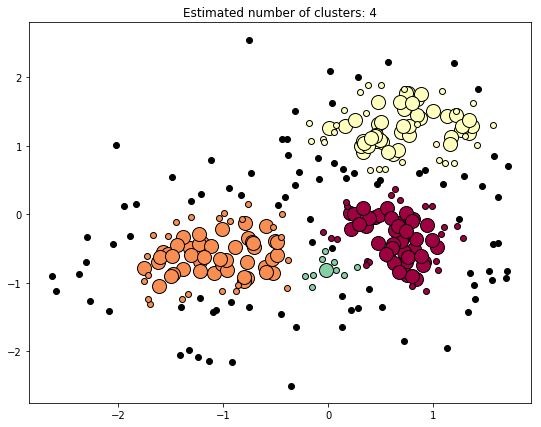

In [23]:
# Altered version of: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

X, labels_true = close_blobs
X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# Plot result
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Gaussian Mixture Model

The daddy of bayesian clustering methods, but pretty complex theory. Basically fits a kernel of your choice to the density of the instances.

Tasks:

- Try changing the number of fitted components
- Try with different datasets (especially non-parametric ones)

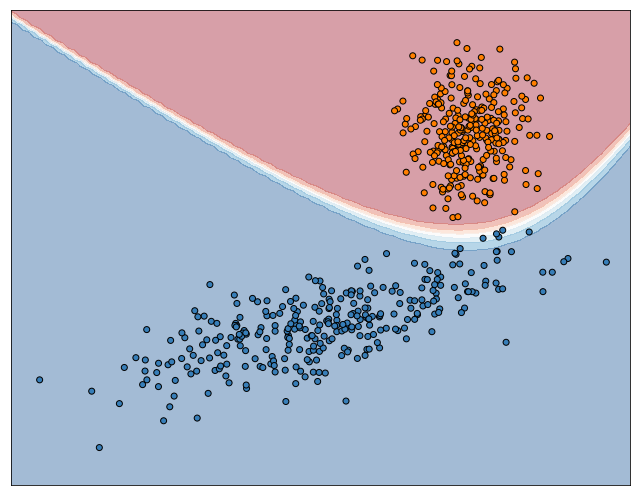

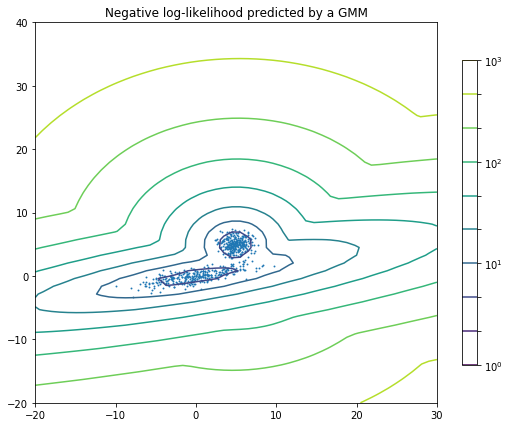

In [24]:
# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([5, 5])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X_train)

fig, ax = plt.subplots(figsize=(9, 7))
plot_single(ax, clf, X_train, clf.predict(X_train))
plt.show()

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

fig, ax = plt.subplots(figsize=(9, 7))
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
ax.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()